# Set Up Environment

In [1]:
# install some libraries
!pip install -U tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflo

## Import Packages

In [2]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import cv2
from tqdm.notebook import tqdm


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from scikitplot.metrics import plot_roc
from torchvision.io import read_image, ImageReadMode

## Define the Hyperparameters

In [3]:
EPOCHS = 65
BATCH_SIZE = 16
CHANNELS = 3
IMAGE_SIZE = 125


# Load the Dataset

In [4]:
# Define paths
DATASET_PATH = "/kaggle/input/skin-diseases-for-10-case/IMG_CLASSES"

## Save the dataset in DataFrame

In [5]:
# get a list of all the directories inside the brain directory
class_dirs = os.listdir(DATASET_PATH)

# create empty lists to store the image names and class names
image_names = []
image_names1 = []
class_names = []

# iterate over each class directory
for class_dir in class_dirs:
    # get the path to the current class directory
    class_path = os.path.join(DATASET_PATH, class_dir)
    
    # iterate over each image file inside the current class directory
    for image_file in os.listdir(class_path):
        # get the path to the current image file
        image_path = os.path.join(class_path, image_file)
        
         # append the image name and class name to their respective lists
        image_names.append(image_path)
        image_names1.append(os.path.join(class_dir, image_file))
        class_names.append(class_dir)
        
# create a dataframe with two columns: image name and class name
df_visualize = pd.DataFrame({'image_name': image_names, 'class_name': class_names}).sample(frac = 1, random_state=73)

# create a dataframe with two columns: image name and class name to train
df_train = pd.DataFrame({'image_name': image_names1, 'class_name': class_names}).sample(frac = 1, random_state=73)


In [6]:
# create a dictionary to map old names to new names
name_map = {"Psoriasis pictures Lichen Planus and related diseases": "Psoriasis and Lichen Planus", "Warts Molluscum and other Viral Infections": "Warts Molluscum", "Tinea Ringworm Candidiasis and other Fungal Infections": "Tinea Ringworm Candidiasis", "Seborrheic Keratoses and other Benign Tumors": "Seborrheic Keratoses"}

# replace the old names with new names in the dataframe
df_visualize = df_visualize.replace({'class_name': name_map})

# replace the old names with new names in the dataframe_train
df_train = df_train.replace({'class_name': name_map})

In [7]:
# Display the dataframe_visualize of dataset
df_visualize

image_name  \
1330   /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
6662   /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
9038   /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
35499  /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
31214  /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
...                                                  ...   
34470  /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
8586   /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
4014   /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
24722  /kaggle/input/skin-diseases-for-10-case/IMG_CL...   
21398  /kaggle/input/skin-diseases-for-10-case/IMG_CL...   

                                class_name  
1330   Benign Keratosis-like Lesions (BKL)  
6662                              Melanoma  
9038                              Melanoma  
35499                      Warts Molluscum  
31214                 Seborrheic Keratoses  
...                                    ...  
34470                      Warts Molluscum  
8586                              Melanoma  
4014                              Melanoma  
24722                     Melanocytic Nevi  
21398                     Melanocytic Nevi  

[35822 rows x 2 columns]

In [8]:
# Display the dataframe_train of dataset
df_train

image_name  \
1330   Benign Keratosis-like Lesions (BKL)/ISIC_00671...   
6662                           Melanoma/ISIC_0067276.jpg   
9038                           Melanoma/ISIC_7563371.jpg   
35499  Warts Molluscum and other Viral Infections/t-c...   
31214  Seborrheic Keratoses and other Benign Tumors/t...   
...                                                  ...   
34470  Warts Molluscum and other Viral Infections/v-w...   
8586                           Melanoma/ISIC_0056863.jpg   
4014                           Melanoma/ISIC_7290233.jpg   
24722                  Melanocytic Nevi/ISIC_0024319.jpg   
21398      Melanocytic Nevi/ISIC_0000055_downsampled.jpg   

                                class_name  
1330   Benign Keratosis-like Lesions (BKL)  
6662                              Melanoma  
9038                              Melanoma  
35499                      Warts Molluscum  
31214                 Seborrheic Keratoses  
...                                    ...  
34470                      Warts Molluscum  
8586                              Melanoma  
4014                              Melanoma  
24722                     Melanocytic Nevi  
21398                     Melanocytic Nevi  

[35822 rows x 2 columns]

## Load class names

In [9]:
# get class names associated with dataset images
categories = ['Atopic Dermatitis', 'Basal Cell Carcinoma', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi', 'Melanoma', 'Psoriasis and Lichen Planus', 'Seborrheic Keratoses', 'Tinea Ringworm Candidiasis', 'Warts Molluscum']
print(categories)

['Atopic Dermatitis', 'Basal Cell Carcinoma', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi', 'Melanoma', 'Psoriasis and Lichen Planus', 'Seborrheic Keratoses', 'Tinea Ringworm Candidiasis', 'Warts Molluscum']


# Exploratory Data Analysis

## Display the Number of images associated with each class

In [10]:
print(f"values of each class in train data: {df_visualize['class_name'].value_counts()}")

values of each class in train data: Melanoma                               7980
Melanocytic Nevi                       7970
Seborrheic Keratoses                   4548
Basal Cell Carcinoma                   3765
Warts Molluscum                        2402
Psoriasis and Lichen Planus            2117
Benign Keratosis-like Lesions (BKL)    2079
Tinea Ringworm Candidiasis             1866
Eczema                                 1714
Atopic Dermatitis                      1381
Name: class_name, dtype: int64


## Display the difference of values between each class

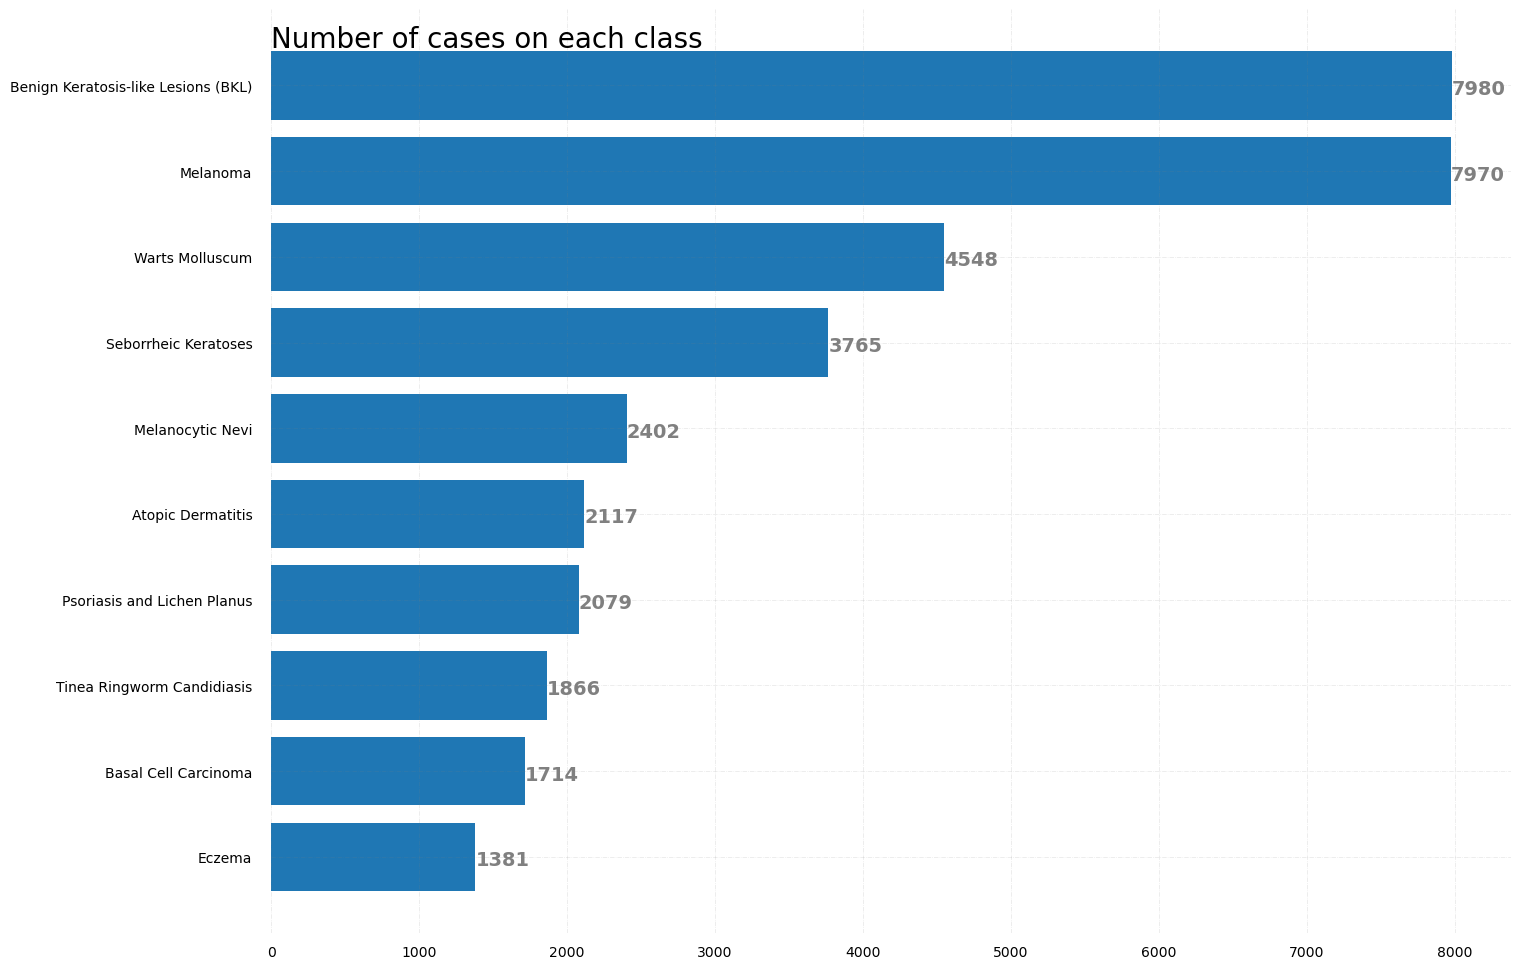

In [11]:
 # Figure Size
fig, ax = plt.subplots(figsize =(16, 12))
 
# Horizontal Bar Plot
ax.barh(df_visualize['class_name'].unique(), df_visualize['class_name'].value_counts())
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 14, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Number of cases on each class', y=0.95, fontsize=20,
             loc ='left')
 
# Show Plot
plt.show()

## Display the percentage of each class in dataset

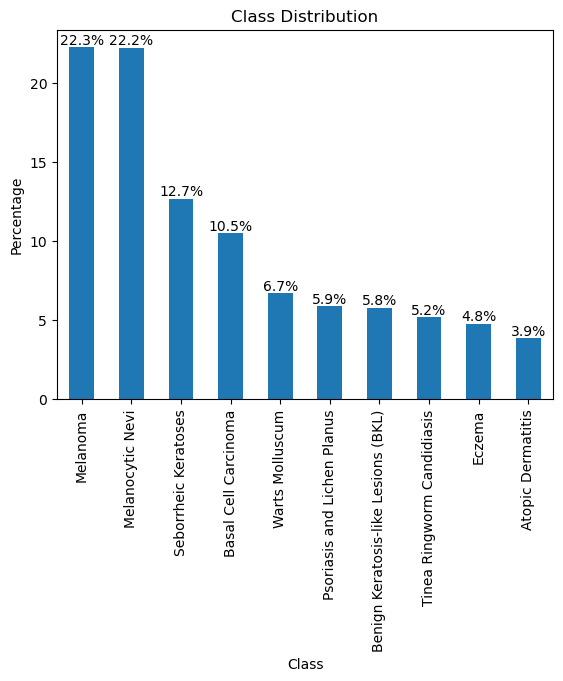

In [12]:
# calculate the percentage of each class in 'col1'
class_percentages = df_visualize['class_name'].value_counts(normalize=True) * 100

# plot the percentage for each class in 'col1' as a bar plot
ax = class_percentages.plot(kind='bar')
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_title('Class Distribution')

# add text annotations to the plot
for i, v in enumerate(class_percentages):
    ax.annotate(f"{v:.1f}%", xy=(i, v), ha='center', va='bottom')

plt.show()

## Display a sample image in each class

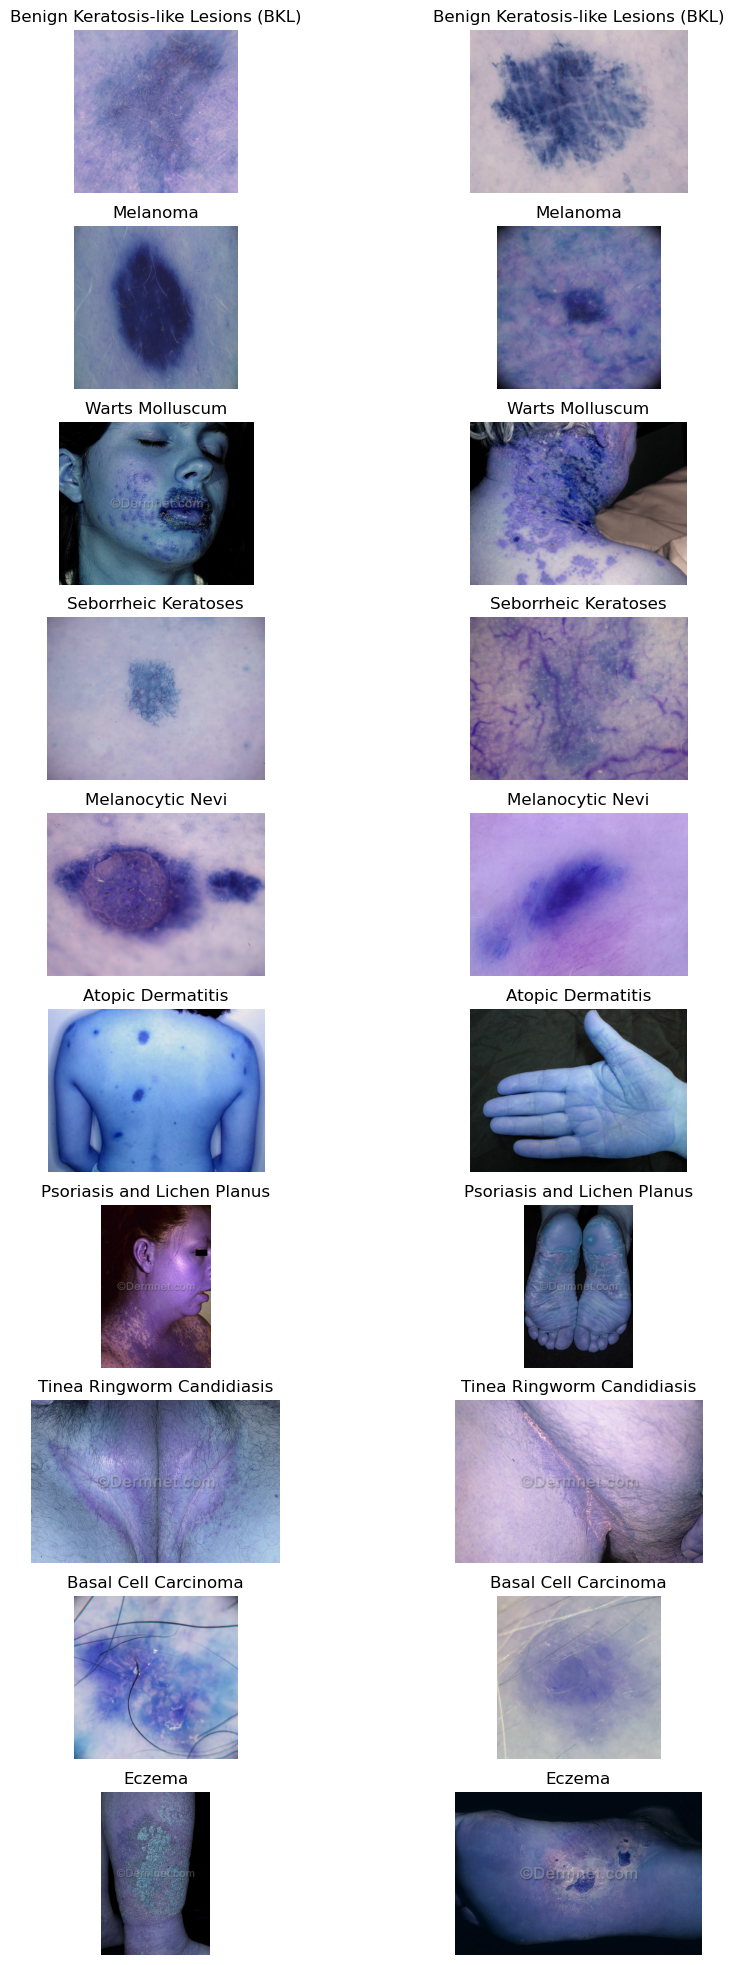

In [13]:
# Display some sample images
fig, axs = plt.subplots(10, 2, figsize=(10, 25))
for i, label in enumerate(df_visualize['class_name'].unique()):
    label_df = df_visualize[df_visualize['class_name'] == label].sample(min(20, len(df_visualize[df_visualize['class_name'] == label])))
    for j, row in label_df.iterrows():
        img = cv2.imread(row['image_name'])
        axs[i, j % 2].imshow(img)
        axs[i, j % 2].axis('off')
        axs[i, j % 2].set_title(label)
plt.show()

# Pre-Processing the data

## Dataset Partitioning

In [14]:
# split the data to train and test
train_d, test_df = train_test_split(df_train, train_size=0.9, random_state=0)
# split the train data to train and validation
train_df, val_df = train_test_split(train_d, train_size=0.9, random_state=0)

In [15]:
# Display how many images for training and validation and testing
print(f"values of each class in train data: {train_df['class_name'].value_counts()}")
print(f"values of each class in validation data: {val_df['class_name'].value_counts()}")
print(f"values of each class in test data: {test_df['class_name'].value_counts()}")

values of each class in train data: Melanocytic Nevi                       6503
Melanoma                               6414
Seborrheic Keratoses                   3709
Basal Cell Carcinoma                   3034
Warts Molluscum                        1973
Psoriasis and Lichen Planus            1718
Benign Keratosis-like Lesions (BKL)    1657
Tinea Ringworm Candidiasis             1503
Eczema                                 1397
Atopic Dermatitis                      1107
Name: class_name, dtype: int64
values of each class in validation data: Melanoma                               746
Melanocytic Nevi                       707
Seborrheic Keratoses                   376
Basal Cell Carcinoma                   363
Warts Molluscum                        216
Benign Keratosis-like Lesions (BKL)    195
Psoriasis and Lichen Planus            179
Tinea Ringworm Candidiasis             176
Eczema                                 143
Atopic Dermatitis                      123
Name: class_name, dtyp

## Image Data Generator for resize and shuffle and encode

In [16]:
# images data generator
train_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, 
                                            directory=DATASET_PATH, # This is the source directory for training images
                                            x_col='image_name', 
                                            y_col='class_name',
                                            color_mode='rgb',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE), # All images will be resized to 224x224
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode='categorical')  

valid_gen = train_datagen.flow_from_dataframe(dataframe = val_df, 
                                            directory=DATASET_PATH, # This is the source directory for training images
                                            x_col='image_name', 
                                            y_col='class_name', 
                                            color_mode='rgb',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE), # All images will be resized to 224x224
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode='categorical')  

test_gen = train_datagen.flow_from_dataframe(dataframe = test_df, 
                                            directory=DATASET_PATH, # This is the source directory for training images
                                            x_col='image_name', 
                                            y_col='class_name', 
                                            color_mode='rgb',
                                            shuffle=True,
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE), # All images will be resized to 224x224
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical') 

Found 29015 validated image filenames belonging to 10 classes.
Found 3224 validated image filenames belonging to 10 classes.
Found 3583 validated image filenames belonging to 10 classes.


# ANN architecture

## Pre-trained model (Extract Features)

In [17]:
ENV = tf.keras.applications.EfficientNetV2S(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Here we freeze the layers 
# Layers are set to trainable as True by default
for layer in ENV.layers:
    layer.trainable = False

82420632/82420632 [==============================] - 3s 0us/step


### Get the pre-trained model Summary

In [18]:
# Summary for the Layers of Pre_trained model
ENV.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 125, 125, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 63, 63, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 63, 63, 24)   96          ['stem_conv[0][0]'

## Define the Architecture

In [19]:
# Create the model achitecture
from keras.models import Model
num_classes = 10
top_model = ENV.output
top_model = tf.keras.layers.GlobalAveragePooling2D()(top_model)
top_model = tf.keras.layers.Dense(256,activation='relu')(top_model)
top_model = tf.keras.layers.Dense(256,activation='relu')(top_model)
top_model = tf.keras.layers.Dense(128,activation='relu')(top_model)
top_model = tf.keras.layers.Dense(128,activation='relu')(top_model)
top_model = tf.keras.layers.Dense(num_classes,activation='softmax')(top_model)

model = Model(inputs = ENV.input, outputs = top_model)


## Compiling the model
### The compilation is performed using one single method call called compile.

The compile method requires several parameters. The loss parameter is specified to have type 'categorical_crossentropy'. The metrics parameter is set to 'accuracy' and finally we use the adam optimizer for training the network.

The output at this stage is shown below −

In [20]:
# create the compiler
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              optimizer=optimizer, 
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Overview of the Architecture

## Visualize The ANN Architecture
(Layers: Input - Hidden - Output) 

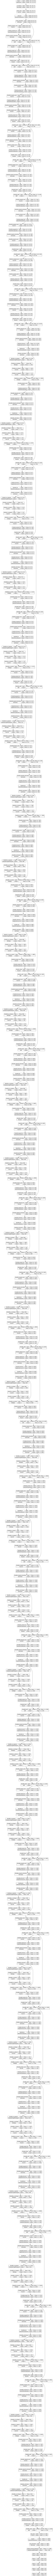

In [21]:
# Visualize the Layers of the Model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

# Training Phase

## Train the ANN model
### The model training is done in one single method call called fit that takes few parameters as seen in the code below

The first two parameters to the fit method specify the features and the output of the training dataset.

The epochs is set to 65; we assume that the training will converge in max 65 epochs - the iterations. 

The trained model is validated on the test data as specified in the last parameter.

In [22]:
# train the model using fit
history = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    validation_data=valid_gen,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/65
1814/1814 [==============================] - 561s 300ms/step - loss: 1.2276 - accuracy: 0.5258 - val_loss: 1.0806 - val_accuracy: 0.5924
Epoch 2/65
1814/1814 [==============================] - 422s 233ms/step - loss: 1.0589 - accuracy: 0.5936 - val_loss: 1.0005 - val_accuracy: 0.6157
Epoch 3/65
1814/1814 [==============================] - 431s 238ms/step - loss: 0.9725 - accuracy: 0.6244 - val_loss: 1.0085 - val_accuracy: 0.6250
Epoch 4/65
1814/1814 [==============================] - 413s 228ms/step - loss: 0.9102 - accuracy: 0.6467 - val_loss: 0.9386 - val_accuracy: 0.6483
Epoch 5/65
1814/1814 [==============================] - 405s 223ms/step - loss: 0.8565 - accuracy: 0.6694 - val_loss: 0.9491 - val_accuracy: 0.6526
Epoch 6/65
1814/1814 [==============================] - 412s 227ms/step - loss: 0.8133 - accuracy: 0.6861 - val_loss: 0.9512 - val_accuracy: 0.6417
Epoch 7/65
1814/1814 [==============================] - 411s 227ms/step - loss: 0.7708 - accuracy: 0.6988 - val_

# Visualizing the model Metrics

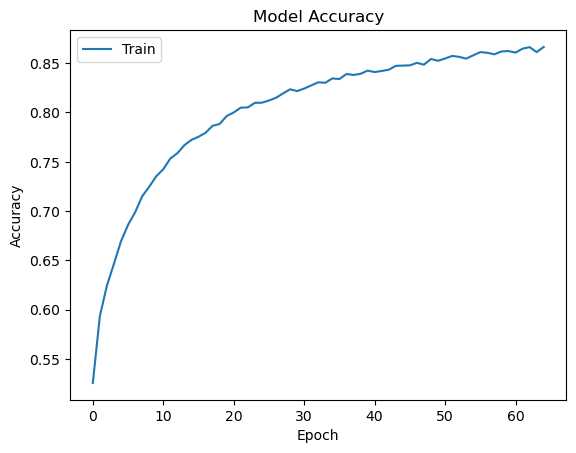

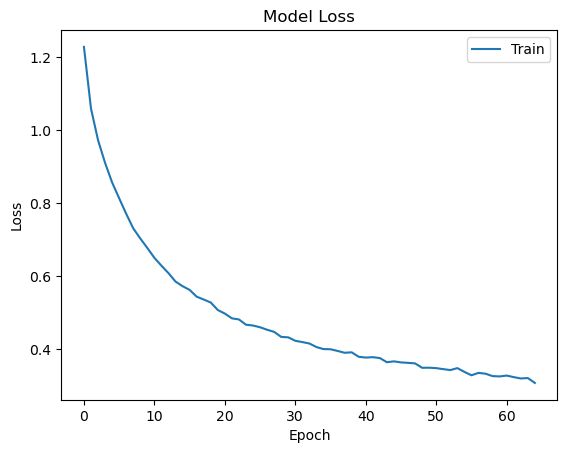

In [23]:
# visualize the model accuracy for the training data
plt.plot(history.history['accuracy'], label='Train')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# visualize the model loss for the training data
plt.plot(history.history['loss'], label='Train')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model Evaluation

In [24]:
# model evaluation to know the accuracy
model.evaluate(test_gen)

224/224 [==============================] - 74s 329ms/step - loss: 1.2556 - accuracy: 0.6980


[1.2556145191192627, 0.6980184316635132]

# Save the model

In [25]:
# save the trained model to use
model.save('/kaggle/working/modelENV_skin_final.h5')

## Save model history

In [26]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Testing the model

1/1 [==============================] - 3s 3s/step


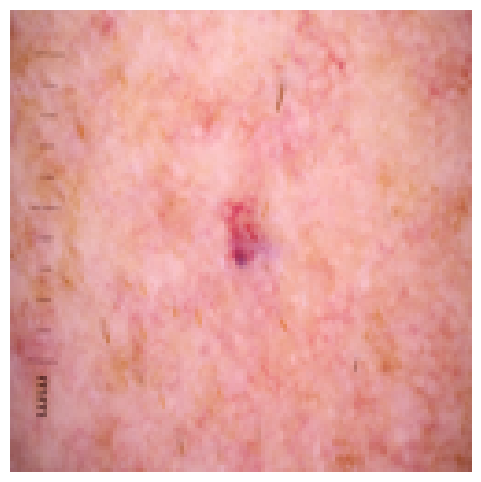

Predicted case -> Melanoma


In [27]:
# Testing the model using sample image
image_path = "/kaggle/input/skin-diseases-for-10-case/IMG_CLASSES/Melanoma/ISIC_7284370.jpg"
image = tf.keras.preprocessing.image.load_img(image_path)
image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
image_array = tf.keras.preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")

# Use model to predict the sample image
pred = model.predict(scaled_img)
# show the output of predicted image
output = categories[np.argmax(pred)]
plt.show()
print("Predicted case ->", output)